In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle
from sklearn.decomposition import PCA
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from catboost import CatBoostRegressor, Pool
from multiprocessing import Pool as mpPool
from multiprocessing import cpu_count
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [2]:
import torch
import numpy as np

from functools import lru_cache, wraps

EPSILON = 1e-6
CACHE_SIZE = 2**13


def random_prices(shape: tuple[int, int]) -> torch.Tensor:
    prices_matrix = torch.cumsum(torch.randn(*shape), dim=0)
    prices_matrix += torch.randn(1, shape[1])
    return prices_matrix

@lru_cache(maxsize=CACHE_SIZE)
def change(prices, lag: int = 1) -> torch.Tensor:
    """
    Computes absolute change in prices.

    Args:
        - `prices` (torch.Tensor): A tensor of shape `(batch_size, n_tradable)`.
        - `lag` (int): The number of periods to lag the prices by.
    Returns:
        torch.Tensor: Absolute change in prices. Shape: `(batch_size, n_tradable)`.
    """
    prices = torch.as_tensor(prices)

    shifted_prices = torch.cat((prices[0].repeat(lag, 1), prices))

    return shifted_prices[lag:] - shifted_prices[:-lag]

def apply_columnwise(s: torch.Tensor, func: callable) -> torch.Tensor:
    """
    Apply a function column-wise to a tensor.

    Result will be cached.

    Args:
        s (torch.Tensor): The input tensor.
        func (callable): The function to apply column-wise.
    """
    if s.dim() == 1:
        return func(s)

    res = torch.zeros_like(s)

    for j in range(s.shape[1]):
        res[:, j] = func(s[:, j])

    return res

def check_linearity(timestamps: np.ndarray, tolerance: float = 0.05) -> bool:
    """Check if timestamps have constant intervals within given tolerance."""
    if len(timestamps) < 2:
        return True

    deltas = np.diff(timestamps)
    
    max_step = np.max(deltas)
    min_step = np.min(deltas)
    is_linear = max_step - min_step <= 2*tolerance*np.median(deltas)
    return bool(is_linear)

In [3]:
data = pd.read_csv('./Train_timeseries.csv')

In [4]:
time_ = data['Date']
# remove time from date
del data['Date']
data.tail()


,Series1,Series2,Series3,Series4,Series5,Series6
938367,-0.763961,-1.670369,1.632822,0.327631,-1.465975,-2.002986
938368,-0.929016,-1.799173,1.903091,0.607440,-1.464328,-2.056986
938369,-1.058803,-1.798737,1.809294,0.673262,-1.462685,-1.881761
938370,-0.996506,-1.798323,1.675207,0.526339,-1.461045,-1.879009
938371,-0.921254,-1.797929,1.805300,0.599747,-1.459408,-1.933551


In [4]:
from datetime import datetime
import pandas as pd

def datetime_to_timestamp(date_series: pd.Series) -> pd.Series:
    """
    Convert datetime strings to Unix timestamps (seconds since epoch)
    
    Args:
        date_series: pandas Series containing datetime strings
        
    Returns:
        pandas Series with Unix timestamps as int64
    """
    # Convert string to datetime if series contains strings
    if date_series.dtype == object:
        date_series = pd.to_datetime(date_series)
    
    # Convert to Unix timestamp (seconds since epoch)
    return date_series.astype('int64')


In [6]:
time_ = datetime_to_timestamp(time_)

In [7]:
check_linearity(time_, tolerance=0.0001)

True

In [8]:
ts = data.values

In [9]:
def fill_with_last(data: np.ndarray) -> np.ndarray:
    """
    Fill NaN values by propagating last valid observation forward using pandas
    
    Args:
        data: Input array with NaN values. Shape: (T, N)
        
    Returns:
        Array with NaN values filled by forward fill
    """
    # Convert to pandas DataFrame for efficient ffill
    df = pd.DataFrame(data)
    
    # Apply forward fill
    filled_df = df.ffill()
    
    return filled_df.values


In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import Ridge

def fill_with_corr_diff(ts):
    """
    Fill NaNs with correlation-based interpolation using regularized regression
    
    Args:
        ts: numpy array of shape (T, N) where T is time steps and N is features
    
    Returns:
        numpy array of shape (T, N) with NaNs filled
    """
    # Convert to pandas DataFrame for easier handling of NaNs
    df = pd.DataFrame(ts)
    T, N = df.shape
    
    # Create a copy to store the results
    filled_df = df.copy()
    
    # Process each time step with NaN values
    nan_timesteps = df.index[df.isna().any(axis=1)]
    
    for t in tqdm(nan_timesteps, desc="Filling missing values"):
        if t == 0:
            # For the first time step, use the next available value
            filled_df.loc[t] = df.loc[t].fillna(method='bfill')
            continue
            
        # Get the mask of NaN values for the current time step
        nan_mask = df.loc[t].isna()
        nan_cols = df.columns[nan_mask]
        
        # Get last known values for the NaN columns
        last_known_values = {}
        for col in nan_cols:
            last_valid_idx = df.loc[:t-1, col].last_valid_index()
            if last_valid_idx is not None:
                last_known_values[col] = df.loc[last_valid_idx, col]
            else:
                # If no previous valid value exists, use next available value
                next_valid_idx = df.loc[t:, col].first_valid_index()
                if next_valid_idx is not None:
                    last_known_values[col] = df.loc[next_valid_idx, col]
                else:
                    # If no valid value exists at all, set to 0
                    last_known_values[col] = 0
        
        for col in nan_cols:
            # Count consecutive NaNs backwards from current position
            consecutive_nans = 0
            curr_t = t
            while curr_t >= 0 and pd.isna(df.loc[curr_t, col]):
                consecutive_nans += 1
                curr_t -= 1
            
            if consecutive_nans == 1:
                # Exactly one NaN - use regression based on other assets' changes
                # Select non-NaN columns for this time step and the previous step
                valid_cols = [c for c in df.columns if c != col and not pd.isna(df.loc[t, c]) and not pd.isna(df.loc[t-1, c])]
                
                if len(valid_cols) > 0:
                    try:
                        # Calculate changes for valid columns for prediction
                        X_pred = np.array([[df.loc[t, c] - df.loc[t-1, c] for c in valid_cols]])
                        
                        # Get historical data for training (avoiding NaNs)
                        train_data = []
                        y_data = []
                        
                        # Look back up to 20 time steps, but avoid index errors
                        for i in range(max(1, t-20), t):
                            # Only use rows where both current and previous values are valid
                            if not pd.isna(df.loc[i, col]) and not pd.isna(df.loc[i-1, col]):
                                # Check if all needed predictors are non-NaN for this row
                                predictors_valid = True
                                row_predictors = []
                                
                                for c in valid_cols:
                                    if pd.isna(df.loc[i, c]) or pd.isna(df.loc[i-1, c]):
                                        predictors_valid = False
                                        break
                                    row_predictors.append(df.loc[i, c] - df.loc[i-1, c])
                                
                                if predictors_valid:
                                    train_data.append(row_predictors)
                                    y_data.append(df.loc[i, col] - df.loc[i-1, col])
                        
                        # Convert to numpy arrays
                        X_train = np.array(train_data)
                        y = np.array(y_data)
                        
                        if len(X_train) >= 3 and len(y) >= 3:  # Need at least a few samples for regression
                            # Remove outliers using IQR method on target variable
                            q1 = np.percentile(y, 25)
                            q3 = np.percentile(y, 75)
                            iqr = q3 - q1
                            lower_bound = q1 - 50 * iqr
                            upper_bound = q3 + 50 * iqr
                            
                            valid_indices = (y >= lower_bound) & (y <= upper_bound)
                            X_train_filtered = X_train[valid_indices]
                            y_filtered = y[valid_indices]
                            
                            if len(X_train_filtered) >= 3:  # Still need enough samples after filtering
                                # Use Ridge regression with regularization instead of LinearRegression
                                model = Ridge(alpha=1.0)  # Alpha controls regularization strength
                                model.fit(X_train_filtered, y_filtered)
                                
                                # Predict the change but bound it to reasonable limits
                                predicted_change = model.predict(X_pred)[0]
                                
                                # Limit change to be within historical range * safety factor
                                max_abs_change = max(abs(y_filtered)) * 1.5
                                predicted_change = max(min(predicted_change, max_abs_change), -max_abs_change)
                                
                                # Apply change to the last known value
                                filled_value = last_known_values[col] + predicted_change
                                
                                # Additional sanity check: value shouldn't change too drastically
                                if abs(filled_value / (last_known_values[col] + 1e-10) - 1) < 0.5:  # Max 50% change
                                    filled_df.loc[t, col] = filled_value
                                    continue
                    except Exception as e:
                        # If any error occurs during regression, fall back to last known value
                        pass
            
            # If multiple NaNs or regression couldn't be applied, use last known value
            filled_df.loc[t, col] = last_known_values[col]
    
    return filled_df.values

In [11]:
ts_filled = fill_with_corr_diff(ts)

Filling missing values: 100%|██████████| 243056/243056 [13:30<00:00, 299.81it/s]


In [119]:
ts_filled_forward = fill_with_last(ts)

In [ ]:

# Create plot with proper labels and title
plt.figure(figsize=(12, 6))
plt.plot(ts_filled - ts_filled_forward, alpha=0.7)
plt.title('Difference Between Correlation-Based Filling and Forward Filling', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Filling Difference', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(ts_filled[-1000:])
plt.show()

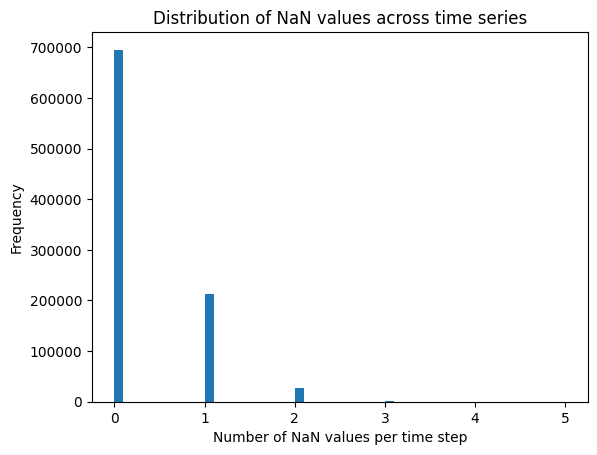

In [12]:
# Plot histogram of NaN counts per time step
nan_mask = np.isnan(ts).astype(int)
plt.hist(np.sum(nan_mask, axis=1), bins=50)
plt.xlabel('Number of NaN values per time step')
plt.ylabel('Frequency')
plt.title('Distribution of NaN values across time series')
plt.show()

In [11]:
# ts_filled = fill_with_arima(ts[-10_000:])
# ts_filled = fill_with_last(ts)

In [ ]:
# ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot_acf(np.diff(ts_filled[-60*4*1000:, 0]), lags=60*4)
plot_pacf((ts_filled[-60*4*1000:, 0]), lags=10)
pass

In [ ]:
ts.shape

In [ ]:
plt.plot(ts_filled[:, 3])
plt.show()

In [ ]:
plt.hist(ts_filled[:, 0], bins=100)
plt.show()


In [ ]:
# corrlation matrix
plt.imshow(np.corrcoef(ts_filled.T))
plt.colorbar()
plt.show()

In [ ]:
# Calculate first differences and handle NaNs
ts_diff = np.diff(ts_filled, axis=0)
ts_diff = np.nan_to_num(ts_diff)

# Plot correlation matrix with labels
plt.figure(figsize=(10, 8))
plt.imshow(np.corrcoef(ts_diff.T), cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix of First Differences')
plt.xlabel('Feature Index')
plt.ylabel('Feature Index')
plt.grid(False)

In [12]:
import torch

from datetime import datetime
import numpy as np


def sma(close_log: torch.Tensor, period: int) -> torch.Tensor:
    """
    Computes Simple Moving Average using cumulative sum approach.
    Handles edge cases where window size exceeds available data.
    
    Args:
        close_log: Input tensor of shape (T, N) where T is time dimension
        period: SMA window size (must be positive)
        
    Returns:
        Tensor: SMA with same shape as input, dtype float32
    """
    if period <= 0:
        raise ValueError(f"Period must be positive, got {period}")
    if close_log.ndim != 2:
        raise ValueError(f"Input must be 2D tensor (T, N), got shape {close_log.shape}")
    
    T, N = close_log.shape
    if T == 0:
        return close_log.clone()
    
    cumsum = torch.cumsum(close_log, dim=0)
    
    if period > T:
        window = torch.arange(1, T+1, device=close_log.device, dtype=torch.float32).view(-1, 1)
        return (cumsum / window).to(close_log.dtype)
    
    # Calculate moving sum using shifted cumulative sums
    shifted = torch.zeros_like(cumsum)
    shifted[period:] = cumsum[:-period]
    moving_sum = cumsum - shifted
    
    # Calculate dynamic window sizes (clipped at period)
    window = torch.arange(1, T+1, device=close_log.device, dtype=torch.float32).view(-1, 1)
    window = torch.minimum(window, torch.tensor(period, dtype=torch.float32, device=close_log.device))
    
    return (moving_sum / window).to(close_log.dtype)


def ema(close_log: torch.Tensor, period: int) -> torch.Tensor:
    """
    Computes Exponential Moving Average (EMA) of a time series using vectorized PyTorch ops.

    Args:
        close_log (torch.Tensor): Time series (T, N), where T — time, N — series.
        period (int): Smoothing period.

    Returns:
        torch.Tensor: EMA of same shape as input.
    """
    alpha = 2 / (period + 1)
    close_log = close_log.float()
    ema = torch.zeros_like(close_log)
    ema[0] = close_log[0]  # init first value to be same

    # recursive EMA computation, vectorized over columns
    for t in range(1, close_log.shape[0]):
        ema[t] = alpha * close_log[t] + (1 - alpha) * ema[t - 1]
    
    return ema

def stdev(series: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates rolling standard deviation of a time series.

    Args:
        series (torch.Tensor): (T, N) tensor where T — time, N — different series (columns).
        period (int): Rolling window size.

    Returns:
        torch.Tensor: (T, N) rolling standard deviation. First few rows will be NaN or zero due to padding.
    """
    T = series.shape[0]
    if period > T:
        raise ValueError("Period can't be greater than time dimension")

    # pad the front so that output shape stays (T, N)
    pad = period - 1
    padded = torch.nn.functional.pad(series.T.unsqueeze(1), (pad, 0), mode='replicate')  # (N, 1, T + pad)

    # unfold to get rolling windows
    unfolded = padded.unfold(dimension=2, size=period, step=1)  # (N, 1, T, period)
    
    # calc std over last dim (window)
    std = unfolded.std(dim=-1)  # (N, 1, T)
    
    return std.squeeze(1).T  # -> (T, N)

import torch.nn.functional as F

def rolling_windows(x: torch.Tensor, period: int) -> torch.Tensor:
    """Helper to create rolling windows: shape (T - period + 1, period, N)"""
    if x.ndim == 1:
        x = x.unsqueeze(-1)
    x = x.T.unsqueeze(0)  # (1, N, T)
    x = F.pad(x, (period - 1, 0), mode='replicate')
    x = x.unfold(dimension=2, size=period, step=1)  # (1, N, T, period)
    return x.squeeze(0).permute(2, 3, 0)  # (T, period, N)

def kurtosis(series: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates rolling kurtosis using PyTorch operations.
    Args:
        series: (T, N)
        period: Rolling window size
    Returns:
        Tensor of same shape as input with rolling kurtosis values
    """
    kurtosis = torch.zeros_like(series)
    
    # Need at least 4 points to calculate kurtosis
    if period < 4:
        raise ValueError("Period must be at least 4 for kurtosis calculation")
    
    # Calculate rolling kurtosis
    for i in tqdm(range(period - 1, series.shape[0])):
        window = series[i - period + 1:i + 1]
        
        # Calculate mean of the window
        mean = torch.mean(window, dim=0)
        
        # Calculate the 2nd and 4th central moments
        diff = window - mean
        variance = torch.mean(diff ** 2, dim=0)
        fourth_moment = torch.mean(diff ** 4, dim=0)
        
        # Avoid division by zero
        safe_variance = torch.where(variance == 0, torch.ones_like(variance), variance)
        
        # Calculate kurtosis: (m⁴/σ⁴) - 3
        # The -3 makes the kurtosis of a normal distribution equal to 0 (excess kurtosis)
        k = fourth_moment / (safe_variance ** 2) - 3
        
        kurtosis[i] = k
    
    return kurtosis

def skewness(series: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates rolling skewness using PyTorch operations.
    Args:
        series: (T, N)
        period: Rolling window size
    Returns:
        Tensor of same shape as input with rolling skewness values
    """
    skewness = torch.zeros_like(series)
    
    # Need at least 3 points to calculate skewness
    if period < 3:
        raise ValueError("Period must be at least 3 for skewness calculation")
    
    # Calculate rolling skewness
    for i in range(period - 1, series.shape[0]):
        window = series[i - period + 1:i + 1]
        
        # Calculate mean of the window
        mean = torch.mean(window, dim=0)
        
        # Calculate the 2nd and 3rd central moments
        diff = window - mean
        variance = torch.mean(diff ** 2, dim=0)
        third_moment = torch.mean(diff ** 3, dim=0)
        
        # Avoid division by zero
        std = torch.sqrt(variance)
        safe_std = torch.where(std == 0, torch.ones_like(std), std)
        
        # Calculate skewness: m³/σ³
        s = third_moment / (safe_std ** 3)
        
        skewness[i] = s
    
    return skewness

def z_score(series: torch.Tensor, period: int) -> torch.Tensor:
    return (series - sma(series, period)) / stdev(series, period)

def vwap(prices: torch.Tensor, volumes: torch.Tensor, period: int) -> torch.Tensor:
    """
    Computes Volume-Weighted Average Price with dynamic window handling.
    Implements both cumulative and rolling window approaches.
    
    Args:
        prices: Tensor of shape (T,) or (T, N) containing price values
        volumes: Tensor of shape (T,) or (T, N) with corresponding volumes
        period: Lookback window size for VWAP calculation
        
    Returns:
        Tensor: VWAP values with same shape as input
    """
    if prices.shape != volumes.shape:
        raise ValueError(f"Prices and volumes must have same shape. Got {prices.shape} vs {volumes.shape}")
    
    if period <= 0:
        raise ValueError(f"Period must be positive, got {period}")
    
    # Calculate price-volume product and cumulative sums
    pv = prices * volumes
    cum_pv = torch.cumsum(pv, dim=0)
    cum_vol = torch.cumsum(volumes, dim=0)
    
    # Handle full-period windows using rolling difference
    if len(prices) > period:
        shifted_pv = torch.zeros_like(cum_pv)
        shifted_pv[period:] = cum_pv[:-period]
        
        shifted_vol = torch.zeros_like(cum_vol)
        shifted_vol[period:] = cum_vol[:-period]
        
        window_pv = cum_pv - shifted_pv
        window_vol = cum_vol - shifted_vol
    else:
        window_pv = cum_pv
        window_vol = cum_vol
    
    # Add epsilon to prevent division by zero
    epsilon = torch.finfo(prices.dtype).eps
    vwap_values = window_pv / (window_vol + epsilon)
    
    # Maintain original dtype
    return vwap_values.to(prices.dtype)


def rsi(close_log: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates the Relative Strength Index (RSI) of a time series.

    Args:
        close_log: Tensor of shape (T, N) containing price values
        period: Lookback window size for RSI calculation
        
    Returns:
        Tensor: RSI values with same shape as input
    """
    T, N = close_log.shape

    delta = close_log[1:] - close_log[:-1]  # (T-1, N)

    gain = torch.clamp(delta, min=0)
    loss = -torch.clamp(delta, max=0)

    avg_gain = torch.zeros((T - 1, N), device=close_log.device)
    avg_loss = torch.zeros((T - 1, N), device=close_log.device)

    avg_gain[period - 1] = gain[:period].mean(dim=0)
    avg_loss[period - 1] = loss[:period].mean(dim=0)

    for t in range(period, T - 1):
        avg_gain[t] = (avg_gain[t - 1] * (period - 1) + gain[t]) / period
        avg_loss[t] = (avg_loss[t - 1] * (period - 1) + loss[t]) / period

    rs = avg_gain / (avg_loss + 1e-8)
    rsi = 100 - 100 / (1 + rs)

    # Padding to match the input length
    rsi_full = torch.zeros((T, N), device=close_log.device)
    rsi_full[period:] = rsi[period - 1:]  # first period values are default 0

    return rsi_full

# from pyriemann.utils.covariance import covariance_mest

# def _corr_from_cov(cov: torch.Tensor) -> torch.Tensor:
#     """
#     Convert covariance matrix to correlation matrix.

#     Args:
#         cov (torch.Tensor): Covariance matrix of shape (N, N)
    
#     Returns:
#         torch.Tensor: Correlation matrix of shape (N, N)
#     """
#     # Compute standard deviations
#     std = torch.sqrt(torch.diag(cov))  # (N,)

#     # Outer product to build denominator matrix
#     denom = std.unsqueeze(0) * std.unsqueeze(1)  # (N, N)

#     # Avoid division by zero (small epsilon)
#     eps = torch.finfo(cov.dtype).eps
#     denom = denom.clamp(min=eps)

#     # Normalize
#     corr = cov / denom

#     # Clamp final output between -1 and 1 (for safety)
#     corr = corr.clamp(-1.0, 1.0)
    
#     return corr

def _corr_from_cov(cov: torch.Tensor) -> torch.Tensor:
    """Преобразование ковариационной матрицы в корреляционную"""
    std = torch.sqrt(torch.diag(cov))
    return cov / (std[:, None] * std[None, :])


# def rolling_tyler_correlation(series: torch.Tensor, period: int) -> torch.Tensor:
#     """
#     Calculates rolling Tyler correlation and flattens upper triangle of correlation matrix.
#     Args:
#         series: (T, N) tensor where T — time, N — different series (columns).
#         period: Rolling window size.
#     Returns:
#         Tensor of shape (T, N*(N-1)//2) with flattened correlations only
#     """
#     # Need at least 2 points to calculate correlation
#     if period < 2:
#         raise ValueError("Period must be at least 2 for correlation calculation")
    
#     n_features = series.shape[1]
#     triu_indices = torch.triu_indices(n_features, n_features, offset=1)
#     n_corr_features = triu_indices.shape[1]
    
#     # Initialize output tensor with zeros
#     correlations = torch.zeros((series.shape[0], n_corr_features), 
#                              device=series.device)
    
#     for i in tqdm(range(period - 1, series.shape[0])):
#         window = series[i - period + 1:i + 1]
#         cov = covariance_mest(window, m_estimator='tyl')
#         corr = _corr_from_cov(cov)
        
#         # Flatten upper triangle of correlation matrix
#         correlations[i] = corr[triu_indices[0], triu_indices[1]]
    
#     return correlations

def rolling_correlation(series: torch.Tensor, period: int, func: callable) -> torch.Tensor:
    """
    Calculates rolling Tyler correlation using pure PyTorch operations.
    Args:
        series: (T, N) tensor where T — time, N — different series (columns).
        period: Rolling window size.
    Returns:
        Tensor of shape (T, N*(N-1)//2) with flattened correlations
    """
    if period < 2:
        raise ValueError("Period must be at least 2 for correlation calculation")

    device = series.device
    n_features = series.size(1)
    triu_indices = torch.triu_indices(n_features, n_features, offset=1)
    
    # Инициализируем выходной тензор
    correlations = torch.zeros((series.size(0), triu_indices.size(1)), device=device)

    for i in tqdm(range(period-1, series.size(0))):
        window = series[i-period+1:i+1]
        
        window_centered = window - window.mean(dim=0, keepdim=True)
        
        cov = func(window_centered)
        corr = _corr_from_cov(cov)
        
        # upper triangle
        correlations[i] = corr[triu_indices[0], triu_indices[1]]
    
    return correlations

def _tyler_covariance_pytorch(X: torch.Tensor, max_iter=100, tol=1e-6) -> torch.Tensor:
    """
    Implementation of Tyler's M-estimator in PyTorch
    """
    n, p = X.size()
    cov = torch.eye(p, device=X.device)
    
    for _ in range(max_iter):
        inv_cov = torch.linalg.pinv(cov)
        dist = torch.einsum('ni,ij,nj->n', X, inv_cov, X)
        weights = p / dist
        new_cov = (X * weights[:, None]).T @ X / n
        new_cov = new_cov / torch.trace(new_cov) * p
        
        if torch.norm(new_cov - cov) < tol:
            break
        cov = new_cov
    
    return cov

def _simple_shrinkage(X: torch.Tensor, shrinkage: float = 0.0) -> torch.Tensor:
    """
    Implementation of simple shrinkage covariance estimator in PyTorch
    Useless for boostings, yes

    Formula:
    $$
    \hat{\Sigma} = (1 - \lambda) \hat{\Sigma} + \lambda \text{diag}(\hat{\Sigma})
    $$

    Args:
        X: (n, p) tensor where n — time samples, p — features.
        shrinkage: Shrinkage parameter [0, 1].
    Returns:
        Covariance matrix with shrinkage (p, p)
    """
    n, p = X.size()
    
    # Compute sample covariance matrix
    X_centered = X - X.mean(dim=0, keepdim=True)
    S = (X_centered.T @ X_centered) / (n - 1)  # Unbiased estimator
    
    # Compute target matrix (diagonal of variances)
    variances = torch.diag(S)
    T = torch.diag(variances)
    
    # Apply shrinkage
    shrunk_cov = (1 - shrinkage) * S + shrinkage * T
    
    # Ensure numerical stability and symmetry
    shrunk_cov = 0.5 * (shrunk_cov + shrunk_cov.T)
    return shrunk_cov
def rolling_min(series: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates the rolling minimum of a time series.
    """
    min_vals = torch.zeros_like(series)
    for i in tqdm(range(period-1, series.size(0))):
        window = series[i-period+1:i+1]
        min_val = window.min(dim=0).values  # Extract values from named tuple
        min_vals[i] = min_val
    return min_vals

def rolling_max(series: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates the rolling maximum of a time series.
    """
    max_vals = torch.zeros_like(series)
    for i in tqdm(range(period-1, series.size(0))):
        window = series[i-period+1:i+1]
        max_val = window.max(dim=0).values  # Extract values from named tuple
        max_vals[i] = max_val
    return max_vals

def stochastic_osciallator(series: torch.Tensor, period: int) -> torch.Tensor:
    """
    Calculates the stochastic oscillator of a time series.
    """
    low = rolling_min(series, period)
    high = rolling_max(series, period)
    return (series - low) / (high - low)

class Winsorizer:
    def __init__(self, factor: float = 0.01):
        self.factor = factor

    def fit(self, x: torch.Tensor, step: int = 1000):
        self.lower_bound = x[::step].quantile(self.factor, dim=0)
        self.upper_bound = x[::step].quantile(1 - self.factor, dim=0)

    def transform(self, x: torch.Tensor) -> torch.Tensor:
        return torch.clamp(x, min=self.lower_bound, max=self.upper_bound)


class GlobalTimeFeatures:
    def __init__(self, timestamp: torch.Tensor):
        # Convert timestamp tensor to datetime objects
        self.datetime = np.array([
            datetime.fromtimestamp(ts.item())
            for ts in timestamp / 10**9
        ])
    
    def day_of_week(self) -> torch.Tensor:
        # Returns tensor with values 0 (Monday) through 6 (Sunday)
        return torch.tensor([
            dt.weekday() 
            for dt in self.datetime
        ], dtype=torch.long).unsqueeze(-1)
    
    def day_of_month(self) -> torch.Tensor:
        # Returns tensor with values 1-31
        return torch.tensor([
            dt.day 
            for dt in self.datetime
        ], dtype=torch.long).unsqueeze(-1)
    
    def month_of_year(self) -> torch.Tensor:
        # Returns tensor with values 1-12
        return torch.tensor([
            dt.month 
            for dt in self.datetime
        ], dtype=torch.long).unsqueeze(-1)
    
    def hour_of_day(self) -> torch.Tensor:
        # Returns tensor with values 0-23
        return torch.tensor([
            dt.hour 
            for dt in self.datetime
        ], dtype=torch.long).unsqueeze(-1)
    
    def minute_of_hour(self) -> torch.Tensor:
        # Returns tensor with values 0-59
        return torch.tensor([
            dt.minute 
            for dt in self.datetime
        ], dtype=torch.long).unsqueeze(-1)

In [ ]:
# # PCA with bar plot visualization

# n_components = 6
# pca = PCA(n_components=n_components)
# pca.fit(np.diff(ts_filled, axis=0))
# # Create bar plot for explained variance
# plt.figure(figsize=(10, 6))
# bars = plt.bar(
#     range(1, n_components + 1), 
#     pca.explained_variance_ratio_,
#     color='skyblue',
#     edgecolor='black'
# )

# # Add value labels on top of each bar
# for bar in bars:
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width()/2., 
#         height,
#         f'{height:.2f}',
#         ha='center',
#         va='bottom'
#     )

# # Add plot labels and title
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Explained Variance Ratio by Principal Components')
# plt.xticks(range(1, 7))
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# plt.show()

# print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")

In [ ]:
plt.plot(ts_filled.cumsum(axis=0))
plt.show()

In [22]:
# # Decompose time series into trend, seasonal, and residual components
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Decompose original time series
# decomp_original = seasonal_decompose(ts_filled, period=60*24, model='additive')  # daily period
# plt.figure(figsize=(12, 8))
# plt.subplot(411)
# plt.plot(ts_filled, label='Original')
# plt.legend()
# plt.subplot(412)
# plt.plot(decomp_original.trend, label='Trend')
# plt.legend()
# plt.subplot(413)
# plt.plot(decomp_original.seasonal, label='Seasonal')
# plt.legend()
# plt.subplot(414)
# plt.plot(decomp_original.resid, label='Residual')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Decompose cumulative sum time series
# decomp_cumsum = seasonal_decompose(ts_filled.cumsum(axis=0), period=60*24, model='additive')
# plt.figure(figsize=(12, 8))
# plt.subplot(411)
# plt.plot(ts_filled.cumsum(axis=0), label='Cumulative Sum')
# plt.legend()
# plt.subplot(412)
# plt.plot(decomp_cumsum.trend, label='Trend')
# plt.legend()
# plt.subplot(413)
# plt.plot(decomp_cumsum.seasonal, label='Seasonal')
# plt.legend()
# plt.subplot(414)
# plt.plot(decomp_cumsum.resid, label='Residual')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [24]:

# # Decompose original time series
# decomp_original = seasonal_decompose(ts_pca, period=60*24, model='additive')  # daily period
# plt.figure(figsize=(12, 8))
# plt.subplot(411)
# plt.plot(ts_filled, label='Original')
# plt.legend()
# plt.subplot(412)
# plt.plot(decomp_original.trend, label='Trend')
# plt.legend()
# plt.subplot(413)
# plt.plot(decomp_original.seasonal, label='Seasonal')
# plt.legend()
# plt.subplot(414)
# plt.plot(decomp_original.resid, label='Residual')
# plt.legend()
# plt.tight_layout()
# plt.show()


# # Decompose original time series
# decomp_original = seasonal_decompose(ts_pca.cumsum(axis=0), period=60*24, model='additive')  # daily period
# plt.figure(figsize=(12, 8))
# plt.subplot(411)
# plt.plot(ts_filled, label='Original')
# plt.legend()
# plt.subplot(412)
# plt.plot(decomp_original.trend, label='Trend')
# plt.legend()
# plt.subplot(413)
# plt.plot(decomp_original.seasonal, label='Seasonal')
# plt.legend()
# plt.subplot(414)
# plt.plot(decomp_original.resid, label='Residual')
# plt.legend()
# plt.tight_layout()
# plt.show()

# No significant seasonals or cycles

In [14]:
ts_filled_tensor = torch.tensor(ts_filled)

# Features

In [ ]:
nan_mask = torch.tensor(nan_mask).float()

In [13]:
# time features

_time_extractor = GlobalTimeFeatures(time_.to_numpy().reshape(-1, 1))
day_of_week = _time_extractor.day_of_week() / 6
day_of_month = _time_extractor.day_of_month() / 31
month_of_year = _time_extractor.month_of_year() / 12
hour_of_day = _time_extractor.hour_of_day() / 23
minute_of_hour = _time_extractor.minute_of_hour() / 59

In [ ]:
ts_filled = torch.tensor(ts_filled)

# Momentum features
mom_1m = change(ts_filled, 1)
mom_5m = change(ts_filled, 5)
mom_1h = change(ts_filled, 60)
mom_2h = change(ts_filled, 2*60)
mom_3h = change(ts_filled, 3*60)
mom_4h = change(ts_filled, 4*60)
mom_1d = change(ts_filled, 60*24)
mom_1w = change(ts_filled, 60*24*7)
mom_1mo = change(ts_filled, 60*24*30)

# Volatility features
real_vol_1h = stdev(mom_1m, 60)
real_vol_2h = stdev(mom_1m, 2*60)
real_vol_3h = stdev(mom_1m, 3*60)
real_vol_1d = stdev(mom_1m, 60*24)
real_vol_1w = stdev(mom_1m, 60*24*7)

# EMA features
_ema_1h_values = ema(ts_filled, 60)
_ema_2h_values = ema(ts_filled, 2*60)
_ema_3h_values = ema(ts_filled, 3*60)
_ema_4h_values = ema(ts_filled, 4*60)
_ema_1d_values = ema(ts_filled, 60*24)
_ema_7d_values = ema(ts_filled, 60*24*7)

ema_1h_slope = torch.diff(_ema_1h_values)
ema_2h_slope = torch.diff(_ema_2h_values)
ema_3h_slope = torch.diff(_ema_3h_values)
ema_4h_slope = torch.diff(_ema_4h_values)
ema_1d_slope = torch.diff(_ema_1d_values)
ema_7d_slope = torch.diff(_ema_7d_values)

ema_1h_minus_sensor = _ema_1h_values - ts_filled
ema_2h_minus_sensor = _ema_2h_values - ts_filled
ema_3h_minus_sensor = _ema_3h_values - ts_filled
ema_4h_minus_sensor = _ema_4h_values - ts_filled
ema_1d_minus_sensor = _ema_1d_values - ts_filled
ema_7d_minus_sensor = _ema_7d_values - ts_filled

sma_ema_diff_1h = sma(ts_filled, 60) - _ema_1h_values
sma_ema_diff_2h = sma(ts_filled, 2*60) - _ema_2h_values
sma_ema_diff_3h = sma(ts_filled, 3*60) - _ema_3h_values
sma_ema_diff_4h = sma(ts_filled, 4*60) - _ema_4h_values
sma_ema_diff_1d = sma(ts_filled, 60*24) - _ema_1d_values
sma_ema_diff_7d = sma(ts_filled, 60*24*7) - _ema_7d_values

# MACD features
macd_1h_2h = _ema_1h_values - _ema_2h_values
macd_1h_3h = _ema_1h_values - _ema_3h_values
macd_1h_4h = _ema_1h_values - _ema_4h_values
macd_1h_1d = _ema_1h_values - _ema_1d_values
macd_1h_7d = _ema_1h_values - _ema_7d_values
macd_2h_3h = _ema_2h_values - _ema_3h_values
macd_2h_4h = _ema_2h_values - _ema_4h_values
macd_2h_1d = _ema_2h_values - _ema_1d_values
macd_2h_7d = _ema_2h_values - _ema_7d_values
macd_3h_4h = _ema_3h_values - _ema_4h_values
macd_3h_1d = _ema_3h_values - _ema_1d_values
macd_3h_7d = _ema_3h_values - _ema_7d_values
macd_4h_1d = _ema_4h_values - _ema_1d_values
macd_4h_7d = _ema_4h_values - _ema_7d_values
macd_1d_7d = _ema_1d_values - _ema_7d_values

# Correlation features
rob_est_corr_12h = rolling_correlation(ts_filled.float(), 60*12, _simple_shrinkage)
rob_est_corr_7d = rolling_correlation(ts_filled.float(), 60*24*7, _simple_shrinkage)

# Statistical features
skewness_1d = skewness(ts_filled, 60*24)
skewness_1w = skewness(ts_filled, 60*24*7)
kurtosis_1d = kurtosis(ts_filled, 60*24)
kurtosis_1w = kurtosis(ts_filled, 60*24*7)

# RSI features
rsi_1h = rsi(ts_filled, 60)
rsi_2h = rsi(ts_filled, 2*60)
rsi_3h = rsi(ts_filled, 3*60)
rsi_4h = rsi(ts_filled, 4*60)
rsi_1d = rsi(ts_filled, 60*24)
rsi_1w = rsi(ts_filled, 60*24*7)

# Stochastic features
stochastic_1h = stochastic_osciallator(ts_filled, 60)
stochastic_2h = stochastic_osciallator(ts_filled, 2*60)
stochastic_3h = stochastic_osciallator(ts_filled, 3*60)
stochastic_4h = stochastic_osciallator(ts_filled, 4*60)
stochastic_1d = stochastic_osciallator(ts_filled, 60*24)
stochastic_1w = stochastic_osciallator(ts_filled, 60*24*7)
stochastic_1mo = stochastic_osciallator(ts_filled, 60*24*30)

In [15]:

# RSI features
rsi_1h = rsi(ts_filled, 60)
rsi_2h = rsi(ts_filled, 2*60)
rsi_3h = rsi(ts_filled, 3*60)
rsi_4h = rsi(ts_filled, 4*60)
rsi_1d = rsi(ts_filled, 60*24)
rsi_1w = rsi(ts_filled, 60*24*7)

# Stochastic features
stochastic_1h = stochastic_osciallator(ts_filled, 60)
stochastic_2h = stochastic_osciallator(ts_filled, 2*60)
stochastic_3h = stochastic_osciallator(ts_filled, 3*60)
stochastic_4h = stochastic_osciallator(ts_filled, 4*60)
stochastic_1d = stochastic_osciallator(ts_filled, 60*24)
stochastic_1w = stochastic_osciallator(ts_filled, 60*24*7)
stochastic_1mo = stochastic_osciallator(ts_filled, 60*24*30)

100%|██████████| 938192/938192 [00:10<00:00, 86610.11it/s]


In [ ]:
# nans_in_hour = sma(nan_mask, 60) / 6 * 10
# nans_in_day = sma(nan_mask, 60*24) / 6 * 10
# nans_in_week = sma(nan_mask, 60*24*7) / 6 * 10
# nans_in_month = sma(nan_mask, 60*24*30) / 6 * 10
# total_nans_in_hour = torch.sum(nans_in_hour, dim=1, keepdim=True)
# total_nans_in_day = torch.sum(nans_in_day, dim=1, keepdim=True)
# total_nans_in_week = torch.sum(nans_in_week, dim=1, keepdim=True)
# total_nans_in_month = torch.sum(nans_in_month, dim=1, keepdim=True)

In [20]:
# Features that require normalization
features_need_norm = torch.cat([
    # Momentum features
    mom_1m, mom_5m, mom_1h, mom_4h, mom_1d, mom_1w, mom_1mo,
    
    # EMA features
    ema_1h_slope, ema_1h_minus_sensor,
    ema_1d_slope, ema_1d_minus_sensor,
    ema_4h_slope, ema_4h_minus_sensor,
    ema_7d_slope, ema_7d_minus_sensor,
    
    # SMA-EMA differences
    sma_ema_diff_1h, sma_ema_diff_1d, sma_ema_diff_4h, sma_ema_diff_7d,
    
    # Volatility features
    real_vol_1h, real_vol_1d, real_vol_1w,
    
    # Statistical features
    skewness_1d, skewness_1w,
    kurtosis_1d, kurtosis_1w, 
    
    # Correlation features
    rob_est_corr_12h, rob_est_corr_7d,

    macd_1h_2h, macd_1h_3h, macd_1h_4h, macd_1h_1d, macd_1h_7d,
    macd_2h_3h, macd_2h_4h, macd_2h_1d, macd_2h_7d,
    macd_3h_4h, macd_3h_1d, macd_3h_7d,
    macd_4h_1d, macd_4h_7d,
    macd_1d_7d,
    
], dim=1)

# Features that don't require normalization
features_no_need_for_norm = torch.cat([
    # RSI features
    rsi_1h, rsi_2h, rsi_3h, rsi_4h, rsi_1d, rsi_1w,
    # Time features
    minute_of_hour, hour_of_day,
    day_of_month, month_of_year, day_of_week,
    
    # Stochastic features
    stochastic_1h, stochastic_2h, stochastic_3h, 
    stochastic_4h, stochastic_1d, stochastic_1w, stochastic_1mo
], dim=1)

NameError: name 'kurtosis_1w' is not defined

In [ ]:
# plt.plot(total_nans_in_hour[-1000:])
# plt.show()

## Winsorization and normalizing
- Winsorizer need to be fited on train set

In [77]:
train_slice_1 = slice(0, int(0.5 * data.shape[0]))
train_slice_2 = slice(train_slice_1.stop, train_slice_1.stop + int(0.25 * data.shape[0]))
train_slice_3 = slice(train_slice_2.stop, train_slice_2.stop + int(0.25 * data.shape[0]))


In [78]:
Q_period = 3 * 30*24
no_norm_features_normed = z_score(features_need_norm, Q_period)

In [119]:
# np.save('final_features_normed.npy', no_norm_features_normed)

In [79]:
no_norm_features_normed_filled = torch.nan_to_num(no_norm_features_normed, nan=0, posinf=0, neginf=0)

In [80]:
winsorizer = Winsorizer(factor=0.005)
winsorizer.fit(no_norm_features_normed_filled[train_slice_1], step=1)

In [81]:
no_norm_features_normed_winsorized = winsorizer.transform(no_norm_features_normed_filled)

In [61]:
winsorizer.lower_bound, winsorizer.upper_bound

(tensor([-3.6574, -4.9546, -4.0360, -4.0037, -5.5237, -3.9103, -3.5901, -4.3387,
         -4.0654, -4.0481, -5.0186, -3.9423, -3.4623, -3.8775, -3.9495, -4.0038,
         -3.4708, -3.8625, -3.0516, -3.3981, -3.4350, -3.3380, -3.1554, -3.3215,
         -3.0756, -3.3647, -3.4468, -3.3638, -2.9032, -3.2036, -3.3443, -3.4545,
         -3.5036, -3.4704, -3.1753, -3.2202, -3.4637, -3.3471, -3.4353, -3.3849,
         -3.1469, -3.2338, -3.3793, -3.4994, -3.4093, -3.6312, -3.1861, -3.8739,
         -3.9801, -4.3073, -4.3568, -4.0104, -4.0764, -3.0988, -3.2611, -3.5091,
         -3.4392, -3.1753, -3.5410, -3.5074, -3.7276, -3.7579, -3.3306, -3.5848,
         -3.2915, -3.2857, -3.3350, -3.4777, -3.1330, -3.7678, -3.7408, -4.0079,
         -4.1600, -3.6185, -3.8885, -3.5711, -4.0056, -4.1462, -4.2147, -3.6708,
         -3.9831, -3.1570, -2.8896, -3.1275, -2.9627, -3.0515, -2.9014, -3.4365,
         -3.5682, -3.5433, -3.6272, -3.2566, -3.5041, -1.7158, -1.7110, -1.5328,
         -1.5335, -1.7646, -

## PCA on features

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
pca.fit(no_norm_features_normed_winsorized)

print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")
print(f'number of components: {pca.n_components_}. total features: {no_norm_features_normed_winsorized.shape[1]}')

In [ ]:
no_norm_features_normed_winsorized_pca = torch.tensor(pca.transform(no_norm_features_normed_winsorized))
n_components = pca.n_components_
no_norm_features_normed_winsorized_pca.shape

In [82]:
features_norm = torch.cat([
    no_norm_features_normed_winsorized, # TODO: PCA. but practically it's not needed
    features_no_need_for_norm,
], dim=1)
features_norm.shape

torch.Size([938372, 241])

In [83]:
features_norm = torch.nan_to_num(features_norm)

# Target

In [84]:
target = torch.roll(mom_4h, -4*60, dims=0)
target[-4*60:] = torch.mean(mom_4h, dim=0)
target.shape

torch.Size([938372, 6])

## Creating sets

In [85]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data - features and target
X = features_norm.float().to(device)
y = target.float().to(device)

X_train_1, y_train_1 = X[train_slice_1], y[train_slice_1]
X_train_2, y_train_2 = X[train_slice_2], y[train_slice_2]
X_train_3, y_train_3 = X[train_slice_3], y[train_slice_3]

# Linear regression

In [86]:
# Create linear regression model with 63 features, 6 targets, and bias term
linreg = torch.nn.Linear(features_norm.shape[1], target.shape[1], bias=True).to(device)  # Move model to GPU

# Define Huber loss function and optimizer with L2 regularization
criterion = torch.nn.HuberLoss().to(device)  # Move loss function to GPU
optimizer = torch.optim.Adam(linreg.parameters(), lr=3e-2, weight_decay=0.01)  # weight_decay for L2 reg

# Training loop
epochs = 100
for epoch in range(epochs):
    # Forward pass
    outputs = linreg(X_train_1)
    loss = criterion(outputs, y_train_1)
    
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: nan
Epoch [20/100], Loss: nan
Epoch [30/100], Loss: nan
Epoch [40/100], Loss: nan
Epoch [50/100], Loss: nan
Epoch [60/100], Loss: nan
Epoch [70/100], Loss: nan
Epoch [80/100], Loss: nan
Epoch [90/100], Loss: nan
Epoch [100/100], Loss: nan


In [87]:
# Test the model
with torch.no_grad():
    test_outputs = linreg(X_train_2)
    test_loss = criterion(test_outputs, y_train_2)
    print(f'Test Loss: {test_loss.item():.4f}')
    
    # Print model's bias terms
    print("Model biases (constant terms):", linreg.bias.cpu())  # Move biases to CPU for printing

Test Loss: nan
Model biases (constant terms): tensor([nan, nan, nan, nan, nan, nan])


In [88]:
def print_corr(predictions, true_values):
    for i in range(predictions.shape[1]):
        corr = np.corrcoef(predictions.T[i], true_values.T[i])[0, 1]
        print(f"Correlation between prediction {i} and true value: {corr:.4f}")

def r_list(predictions, true_values):
    return [np.corrcoef(predictions.T[i], true_values.T[i])[0, 1] for i in range(predictions.shape[1])]

def r2_from_list(r_list):
    r2_list = np.array(r_list)**2
    return np.mean(r2_list)

def r2(predictions: torch.Tensor, true_values: torch.Tensor) -> float:
    """Calculate R-squared (coefficient of determination) score.
    
    Args:
        predictions: Model predictions tensor of shape (n_samples, n_targets)
        true_values: Ground truth values tensor of shape (n_samples, n_targets)
        
    Returns:
        R-squared score as float. Can be negative if model performs worse than mean baseline.
    """
    # Calculate sum of squared residuals
    ss_res = torch.sum((true_values - predictions) ** 2)
    # Calculate total sum of squares
    ss_tot = torch.sum((true_values - torch.mean(true_values)) ** 2)
    # Calculate R-squared
    return (1 - ss_res / ss_tot).item()

In [118]:
# Computing average R^2
linreg_pred = linreg(X_train_3)
r2_linreg = r2(linreg_pred, y_train_3)
print(f"Average R^2: {r2_linreg:.4f}")
r2_from_list(r_list(linreg_pred.detach().cpu(), y_train_3.detach().cpu()))

Average R^2: nan


nan

In [90]:
test_linreg = X_train_3

In [71]:
# # Plot histograms of each feature with feature number in label
# for i in range(X.shape[1]):
#     plt.hist(X[:, i].cpu(), bins=100)
#     plt.title(f'Feature {i+1} Distribution')
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.show()


# CatBoost

In [91]:
def _predict_model(model_and_data: tuple[CatBoostRegressor, np.ndarray]) -> np.ndarray:
    """Helper function for parallel prediction"""
    model, X_np = model_and_data
    return model.predict(X_np)


class MultiTargetCatBoost:
    def __init__(self, base_model: CatBoostRegressor):
        """Initialize multi-target CatBoost model
        
        Args:
            base_model: Base CatBoostRegressor model to clone for each target
        """
        self.base_model = base_model
        self.models: list[CatBoostRegressor] = []
        
    def _convert_tensor(self, data: torch.Tensor | np.ndarray) -> np.ndarray:
        """Convert tensor to numpy array, handling CUDA tensors"""
        if isinstance(data, torch.Tensor):
            return data.cpu().numpy()
        return data

    def fit(self, 
            train_X: torch.Tensor | np.ndarray, 
            train_y: torch.Tensor | np.ndarray,
            val_X: torch.Tensor | np.ndarray,
            val_y: torch.Tensor | np.ndarray) -> None:
        """Fit separate models for each target column
        
        Args:
            train_X: Training features (n_samples, n_features)
            train_y: Training targets (n_samples, n_targets)
            val_X: Validation features
            val_y: Validation targets
        """
        # Convert all inputs to numpy arrays
        train_X = self._convert_tensor(train_X)
        train_y = self._convert_tensor(train_y)
        val_X = self._convert_tensor(val_X)
        val_y = self._convert_tensor(val_y)

        self.models = []
        for col in tqdm(range(train_y.shape[1]), desc="Training models"):
            model = self.base_model.copy()
            train_pool = Pool(train_X, train_y[:, col])
            val_pool = Pool(val_X, val_y[:, col])
            model.fit(train_pool, eval_set=val_pool)
            self.models.append(model)

    def predict(self, X: torch.Tensor | np.ndarray) -> np.ndarray:
        """Predict all target columns using multiprocessing
        
        Args:
            X: Input tensor/array of shape (n_samples, n_features)
            
        Returns:
            Predictions array of shape (n_samples, n_targets)
        """
        X_np = self._convert_tensor(X)
        args = [(model, X_np) for model in self.models]
        
        with mpPool(processes=cpu_count()) as pool:
            preds = pool.map(_predict_model, args)
            
        return np.stack(preds, axis=1)


In [ ]:
import optuna

def objective(trial):
    # Define hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'depth': trial.suggest_int('depth', 6, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 20),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 100),
        'has_time': trial.suggest_categorical('has_time', [True, False])
    }
    
    # Create base model with trial parameters
    base_model = CatBoostRegressor(
        **params,
        task_type="CPU",
        verbose=0,
        use_best_model=True
    )
    
    # Initialize and train multi-target model
    model = MultiTargetCatBoost(base_model)
    model.fit(X_train_1, y_train_1, X_train_2, y_train_2)
    
    # Get predictions and calculate R2
    preds = model.predict(X_train_2)
    preds_tensor = torch.tensor(preds).cpu().detach()
    y_true = y_train_2.cpu().detach()
    
    return r2_from_list(r_list(preds_tensor, y_true))

# Create and run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [96]:
# best_params

# {'iterations': 1879,
#  'learning_rate': 0.0010173196627404298,
#  'depth': 12,
#  'l2_leaf_reg': 4.216030631283651,
#  'early_stopping_rounds': 52,
#  'has_time': True}

{'iterations': 1879,
 'learning_rate': 0.0010173196627404298,
 'depth': 12,
 'l2_leaf_reg': 4.216030631283651,
 'early_stopping_rounds': 52,
 'has_time': True}

In [103]:
# # Get best parameters and create final model
# best_params = study.best_params
# base_model = CatBoostRegressor(
#     iterations=2000,
#     learning_rate=0.001,
#     depth=10,
#     l2_leaf_reg=4.5,
#     early_stopping_rounds=52,
#     has_time=True,
#     task_type="GPU",
#     verbose=100,
#     use_best_model=True
# )
# catboost_multi_target = MultiTargetCatBoost(base_model)
# catboost_multi_target.fit(X_train_1, y_train_1, X_train_2, y_train_2)

# 0.171

Training models:   0%|          | 0/6 [00:00<?, ?it/s]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.2702804	test: 1.2432477	best: 1.2432477 (0)	total: 58.8ms	remaining: 1m 45s
100:	learn: 1.2474059	test: 1.2283950	best: 1.2283950 (100)	total: 2.39s	remaining: 40.2s
200:	learn: 1.2269039	test: 1.2161427	best: 1.2161427 (200)	total: 4.65s	remaining: 37s
300:	learn: 1.2083479	test: 1.2061124	best: 1.2061124 (300)	total: 6.92s	remaining: 34.4s
400:	learn: 1.1912048	test: 1.1975819	best: 1.1975819 (400)	total: 9.19s	remaining: 32.1s
500:	learn: 1.1752148	test: 1.1904058	best: 1.1904058 (500)	total: 11.5s	remaining: 29.7s
600:	learn: 1.1604179	test: 1.1843868	best: 1.1843868 (600)	total: 13.8s	remaining: 27.5s
700:	learn: 1.1465957	test: 1.1793628	best: 1.1793628 (700)	total: 16.1s	remaining: 25.2s
800:	learn: 1.1337850	test: 1.1752250	best: 1.1752250 (800)	total: 18.3s	remaining: 22.9s
900:	learn: 1.1216625	test: 1.1715960	best: 1.1715960 (900)	total: 20.6s	remaining: 20.6s
1000:	learn: 1.1099424	test: 1.1686577	best: 1.1686577 (1000)	total: 22.9s	remaining: 18.3s
1100:	learn:

Training models:  17%|█▋        | 1/6 [00:43<03:35, 43.01s/it]

1799:	learn: 1.0267927	test: 1.1575522	best: 1.1575522 (1799)	total: 41.8s	remaining: 0us
bestTest = 1.157552168
bestIteration = 1799


0:	learn: 1.3759762	test: 1.3740258	best: 1.3740258 (0)	total: 23ms	remaining: 41.3s
100:	learn: 1.3477549	test: 1.3545268	best: 1.3545268 (100)	total: 2.31s	remaining: 38.8s
200:	learn: 1.3233197	test: 1.3375560	best: 1.3375560 (200)	total: 4.57s	remaining: 36.3s
300:	learn: 1.3013932	test: 1.3228842	best: 1.3228842 (300)	total: 6.85s	remaining: 34.1s
400:	learn: 1.2815876	test: 1.3100702	best: 1.3100702 (400)	total: 9.16s	remaining: 32s
500:	learn: 1.2636163	test: 1.2988868	best: 1.2988868 (500)	total: 11.5s	remaining: 29.8s
600:	learn: 1.2473101	test: 1.2892896	best: 1.2892896 (600)	total: 13.8s	remaining: 27.6s
700:	learn: 1.2323494	test: 1.2812014	best: 1.2812014 (700)	total: 16.2s	remaining: 25.4s
800:	learn: 1.2185555	test: 1.2744696	best: 1.2744696 (800)	total: 18.6s	remaining: 23.2s
900:	learn: 1.2055990	test: 1.2687517	best: 1.2687517 (900)	total: 21s	remaining: 20.9s
1000:	learn: 1.1932348	test: 1.2640154	best: 1.2640154 (1000)	total: 23.4s	remaining: 18.7s
1100:	learn: 1.18

Training models:  33%|███▎      | 2/6 [01:27<02:55, 43.93s/it]

1799:	learn: 1.1105823	test: 1.2457954	best: 1.2457954 (1799)	total: 43.2s	remaining: 0us
bestTest = 1.245795446
bestIteration = 1799


0:	learn: 1.4101234	test: 1.3823119	best: 1.3823119 (0)	total: 22ms	remaining: 39.6s
100:	learn: 1.3799504	test: 1.3602675	best: 1.3602675 (100)	total: 2.38s	remaining: 40s
200:	learn: 1.3535399	test: 1.3419015	best: 1.3419015 (200)	total: 4.77s	remaining: 38s
300:	learn: 1.3299163	test: 1.3267388	best: 1.3267388 (300)	total: 7.18s	remaining: 35.7s
400:	learn: 1.3090342	test: 1.3140262	best: 1.3140262 (400)	total: 9.56s	remaining: 33.3s
500:	learn: 1.2901665	test: 1.3031642	best: 1.3031642 (500)	total: 12s	remaining: 31s
600:	learn: 1.2731352	test: 1.2939333	best: 1.2939333 (600)	total: 14.3s	remaining: 28.6s
700:	learn: 1.2577520	test: 1.2859646	best: 1.2859646 (700)	total: 16.7s	remaining: 26.2s
800:	learn: 1.2435745	test: 1.2793294	best: 1.2793294 (800)	total: 19.1s	remaining: 23.8s
900:	learn: 1.2300946	test: 1.2737379	best: 1.2737379 (900)	total: 21.5s	remaining: 21.4s
1000:	learn: 1.2171140	test: 1.2691201	best: 1.2691201 (1000)	total: 23.9s	remaining: 19.1s
1100:	learn: 1.204457

Training models:  50%|█████     | 3/6 [02:13<02:14, 44.67s/it]

1799:	learn: 1.1294551	test: 1.2512939	best: 1.2512939 (1799)	total: 44.1s	remaining: 0us
bestTest = 1.25129386
bestIteration = 1799


0:	learn: 1.4012963	test: 1.3341606	best: 1.3341606 (0)	total: 24.9ms	remaining: 44.7s
100:	learn: 1.3696432	test: 1.3124108	best: 1.3124108 (100)	total: 2.63s	remaining: 44.2s
200:	learn: 1.3414551	test: 1.2943243	best: 1.2943243 (200)	total: 5.29s	remaining: 42.1s
300:	learn: 1.3159921	test: 1.2791276	best: 1.2791276 (300)	total: 7.96s	remaining: 39.6s
400:	learn: 1.2931838	test: 1.2661960	best: 1.2661960 (400)	total: 10.6s	remaining: 36.8s
500:	learn: 1.2723023	test: 1.2554135	best: 1.2554135 (500)	total: 13.2s	remaining: 34.1s
600:	learn: 1.2535910	test: 1.2461737	best: 1.2461737 (600)	total: 15.7s	remaining: 31.3s
700:	learn: 1.2365623	test: 1.2386397	best: 1.2386397 (700)	total: 18.3s	remaining: 28.6s
800:	learn: 1.2207836	test: 1.2319853	best: 1.2319853 (800)	total: 20.8s	remaining: 25.9s
900:	learn: 1.2059331	test: 1.2265325	best: 1.2265325 (900)	total: 23.4s	remaining: 23.3s
1000:	learn: 1.1919055	test: 1.2220919	best: 1.2220919 (1000)	total: 25.9s	remaining: 20.7s
1100:	learn

Training models:  67%|██████▋   | 4/6 [03:01<01:32, 46.12s/it]

1799:	learn: 1.0997609	test: 1.2047878	best: 1.2047878 (1799)	total: 46.8s	remaining: 0us
bestTest = 1.204787795
bestIteration = 1799


0:	learn: 1.3295680	test: 1.3530542	best: 1.3530542 (0)	total: 21.9ms	remaining: 39.4s
100:	learn: 1.3012438	test: 1.3301508	best: 1.3301508 (100)	total: 2.4s	remaining: 40.4s
200:	learn: 1.2768744	test: 1.3121573	best: 1.3121573 (200)	total: 4.83s	remaining: 38.4s
300:	learn: 1.2555926	test: 1.2976142	best: 1.2976142 (300)	total: 7.3s	remaining: 36.4s
400:	learn: 1.2369107	test: 1.2856461	best: 1.2856461 (400)	total: 9.76s	remaining: 34s
500:	learn: 1.2204135	test: 1.2757011	best: 1.2757011 (500)	total: 12.2s	remaining: 31.6s
600:	learn: 1.2056864	test: 1.2675080	best: 1.2675080 (600)	total: 14.8s	remaining: 29.5s
700:	learn: 1.1924859	test: 1.2608088	best: 1.2608088 (700)	total: 17.3s	remaining: 27.1s
800:	learn: 1.1805850	test: 1.2550185	best: 1.2550185 (800)	total: 19.8s	remaining: 24.7s
900:	learn: 1.1693579	test: 1.2502196	best: 1.2502196 (900)	total: 22.4s	remaining: 22.3s
1000:	learn: 1.1589534	test: 1.2461416	best: 1.2461416 (1000)	total: 25s	remaining: 19.9s
1100:	learn: 1.14

Training models:  83%|████████▎ | 5/6 [03:50<00:47, 47.04s/it]

1799:	learn: 1.0891055	test: 1.2314110	best: 1.2314110 (1799)	total: 46.9s	remaining: 0us
bestTest = 1.231410995
bestIteration = 1799


0:	learn: 1.3207390	test: 1.2397355	best: 1.2397355 (0)	total: 23ms	remaining: 41.4s
100:	learn: 1.2941088	test: 1.2216197	best: 1.2216197 (100)	total: 2.59s	remaining: 43.5s
200:	learn: 1.2703841	test: 1.2067576	best: 1.2067576 (200)	total: 5.21s	remaining: 41.5s
300:	learn: 1.2490914	test: 1.1947661	best: 1.1947661 (300)	total: 7.86s	remaining: 39.2s
400:	learn: 1.2297523	test: 1.1851375	best: 1.1851375 (400)	total: 10.5s	remaining: 36.8s
500:	learn: 1.2122642	test: 1.1769101	best: 1.1769101 (500)	total: 13.2s	remaining: 34.2s
600:	learn: 1.1958955	test: 1.1700760	best: 1.1700760 (600)	total: 15.9s	remaining: 31.7s
700:	learn: 1.1804869	test: 1.1645681	best: 1.1645681 (700)	total: 18.6s	remaining: 29.2s
800:	learn: 1.1659121	test: 1.1598818	best: 1.1598818 (800)	total: 21.4s	remaining: 26.7s
900:	learn: 1.1520628	test: 1.1560036	best: 1.1560036 (900)	total: 24.2s	remaining: 24.2s
1000:	learn: 1.1388540	test: 1.1526688	best: 1.1526688 (1000)	total: 27s	remaining: 21.6s
1100:	learn: 1.

Training models: 100%|██████████| 6/6 [04:41<00:00, 46.97s/it]

1799:	learn: 1.0485328	test: 1.1398161	best: 1.1398161 (1799)	total: 49.8s	remaining: 0us
bestTest = 1.139816062
bestIteration = 1799


In [108]:
# Get best parameters and create final model
base_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.001,
    depth=10,
    l2_leaf_reg=4.5,
    early_stopping_rounds=52,
    has_time=True,
    task_type="GPU",
    verbose=100,
    use_best_model=True
)
catboost_multi_target = MultiTargetCatBoost(base_model)
catboost_multi_target.fit(X_train_1, y_train_1, X_train_2, y_train_2)

Training models:   0%|          | 0/6 [00:00<?, ?it/s]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.2702475	test: 1.2432499	best: 1.2432499 (0)	total: 41.3ms	remaining: 1m 22s
100:	learn: 1.2433290	test: 1.2283809	best: 1.2283809 (100)	total: 3.5s	remaining: 1m 5s
200:	learn: 1.2192691	test: 1.2160881	best: 1.2160881 (200)	total: 6.95s	remaining: 1m 2s
300:	learn: 1.1971377	test: 1.2058061	best: 1.2058061 (300)	total: 10.4s	remaining: 58.9s
400:	learn: 1.1763866	test: 1.1973379	best: 1.1973379 (400)	total: 13.9s	remaining: 55.6s
500:	learn: 1.1570407	test: 1.1901593	best: 1.1901593 (500)	total: 17.4s	remaining: 52.1s
600:	learn: 1.1387794	test: 1.1841807	best: 1.1841807 (600)	total: 20.9s	remaining: 48.7s
700:	learn: 1.1215766	test: 1.1790679	best: 1.1790679 (700)	total: 24.4s	remaining: 45.3s
800:	learn: 1.1054794	test: 1.1747539	best: 1.1747539 (800)	total: 27.9s	remaining: 41.8s
900:	learn: 1.0903402	test: 1.1710846	best: 1.1710846 (900)	total: 31.4s	remaining: 38.3s
1000:	learn: 1.0761900	test: 1.1681171	best: 1.1681171 (1000)	total: 35s	remaining: 34.9s
1100:	learn: 

Training models:  17%|█▋        | 1/6 [01:14<06:13, 74.66s/it]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.3759439	test: 1.3740268	best: 1.3740268 (0)	total: 35ms	remaining: 1m 9s
100:	learn: 1.3445104	test: 1.3545846	best: 1.3545846 (100)	total: 3.77s	remaining: 1m 10s
200:	learn: 1.3170288	test: 1.3379127	best: 1.3379127 (200)	total: 7.49s	remaining: 1m 7s
300:	learn: 1.2920741	test: 1.3234816	best: 1.3234816 (300)	total: 11.2s	remaining: 1m 3s
400:	learn: 1.2693028	test: 1.3107085	best: 1.3107085 (400)	total: 15s	remaining: 59.8s
500:	learn: 1.2484689	test: 1.2998137	best: 1.2998137 (500)	total: 18.8s	remaining: 56.2s
600:	learn: 1.2292970	test: 1.2902643	best: 1.2902643 (600)	total: 22.6s	remaining: 52.6s
700:	learn: 1.2117494	test: 1.2822059	best: 1.2822059 (700)	total: 26.4s	remaining: 49s
800:	learn: 1.1948311	test: 1.2753528	best: 1.2753528 (800)	total: 30.4s	remaining: 45.5s
900:	learn: 1.1792250	test: 1.2697464	best: 1.2697464 (900)	total: 34.3s	remaining: 41.9s
1000:	learn: 1.1638115	test: 1.2651184	best: 1.2651184 (1000)	total: 38.3s	remaining: 38.2s
1100:	learn: 1.1

Training models:  33%|███▎      | 2/6 [02:35<05:12, 78.10s/it]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.4100910	test: 1.3822996	best: 1.3822996 (0)	total: 33.4ms	remaining: 1m 6s
100:	learn: 1.3764900	test: 1.3603583	best: 1.3603583 (100)	total: 3.96s	remaining: 1m 14s
200:	learn: 1.3466284	test: 1.3419750	best: 1.3419750 (200)	total: 7.88s	remaining: 1m 10s
300:	learn: 1.3199147	test: 1.3269218	best: 1.3269218 (300)	total: 11.8s	remaining: 1m 6s
400:	learn: 1.2957779	test: 1.3140659	best: 1.3140659 (400)	total: 15.7s	remaining: 1m 2s
500:	learn: 1.2739934	test: 1.3034766	best: 1.3034766 (500)	total: 19.6s	remaining: 58.5s
600:	learn: 1.2538004	test: 1.2943708	best: 1.2943708 (600)	total: 23.4s	remaining: 54.5s
700:	learn: 1.2354657	test: 1.2863371	best: 1.2863371 (700)	total: 27.3s	remaining: 50.5s
800:	learn: 1.2183565	test: 1.2796453	best: 1.2796453 (800)	total: 31.1s	remaining: 46.6s
900:	learn: 1.2018293	test: 1.2739625	best: 1.2739625 (900)	total: 35.1s	remaining: 42.8s
1000:	learn: 1.1863554	test: 1.2693611	best: 1.2693611 (1000)	total: 39s	remaining: 38.9s
1100:	learn

Training models:  50%|█████     | 3/6 [03:56<03:58, 79.61s/it]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.4012506	test: 1.3341710	best: 1.3341710 (0)	total: 37.2ms	remaining: 1m 14s
100:	learn: 1.3650603	test: 1.3128976	best: 1.3128976 (100)	total: 4.26s	remaining: 1m 20s
200:	learn: 1.3322288	test: 1.2953341	best: 1.2953341 (200)	total: 8.56s	remaining: 1m 16s
300:	learn: 1.3021540	test: 1.2802145	best: 1.2802145 (300)	total: 12.9s	remaining: 1m 12s
400:	learn: 1.2752217	test: 1.2672746	best: 1.2672746 (400)	total: 17s	remaining: 1m 7s
500:	learn: 1.2507796	test: 1.2565787	best: 1.2565787 (500)	total: 21.2s	remaining: 1m 3s
600:	learn: 1.2285632	test: 1.2471218	best: 1.2471218 (600)	total: 25.2s	remaining: 58.7s
700:	learn: 1.2077396	test: 1.2394300	best: 1.2394300 (700)	total: 29.3s	remaining: 54.4s
800:	learn: 1.1887160	test: 1.2329099	best: 1.2329099 (800)	total: 33.4s	remaining: 50s
900:	learn: 1.1706819	test: 1.2273680	best: 1.2273680 (900)	total: 37.4s	remaining: 45.7s
1000:	learn: 1.1536260	test: 1.2227422	best: 1.2227422 (1000)	total: 41.5s	remaining: 41.4s
1100:	learn

Training models:  67%|██████▋   | 4/6 [05:20<02:42, 81.33s/it]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.3295494	test: 1.3530582	best: 1.3530582 (0)	total: 32.9ms	remaining: 1m 5s
100:	learn: 1.2993107	test: 1.3300837	best: 1.3300837 (100)	total: 3.68s	remaining: 1m 9s
200:	learn: 1.2728851	test: 1.3117782	best: 1.3117782 (200)	total: 7.39s	remaining: 1m 6s
300:	learn: 1.2495714	test: 1.2968942	best: 1.2968942 (300)	total: 11.1s	remaining: 1m 2s
400:	learn: 1.2287049	test: 1.2849828	best: 1.2849828 (400)	total: 14.9s	remaining: 59.3s
500:	learn: 1.2100594	test: 1.2751293	best: 1.2751293 (500)	total: 18.6s	remaining: 55.7s
600:	learn: 1.1932444	test: 1.2669786	best: 1.2669786 (600)	total: 22.4s	remaining: 52.2s
700:	learn: 1.1780772	test: 1.2601378	best: 1.2601378 (700)	total: 26.2s	remaining: 48.6s
800:	learn: 1.1639866	test: 1.2543274	best: 1.2543274 (800)	total: 30s	remaining: 45s
900:	learn: 1.1507787	test: 1.2494943	best: 1.2494943 (900)	total: 34s	remaining: 41.4s
1000:	learn: 1.1381826	test: 1.2454262	best: 1.2454262 (1000)	total: 38s	remaining: 37.9s
1100:	learn: 1.1262

Training models:  83%|████████▎ | 5/6 [06:42<01:21, 81.57s/it]Warning: less than 75% GPU memory available for training. Free: 2139.375 Total: 5815.3125


0:	learn: 1.3207003	test: 1.2397298	best: 1.2397298 (0)	total: 34.4ms	remaining: 1m 8s
100:	learn: 1.2902824	test: 1.2214963	best: 1.2214963 (100)	total: 3.9s	remaining: 1m 13s
200:	learn: 1.2628431	test: 1.2066471	best: 1.2066471 (200)	total: 7.72s	remaining: 1m 9s
300:	learn: 1.2377419	test: 1.1945102	best: 1.1945102 (300)	total: 11.7s	remaining: 1m 6s
400:	learn: 1.2144863	test: 1.1847076	best: 1.1847076 (400)	total: 15.6s	remaining: 1m 2s
500:	learn: 1.1933316	test: 1.1766313	best: 1.1766313 (500)	total: 19.6s	remaining: 58.6s
600:	learn: 1.1736729	test: 1.1698263	best: 1.1698263 (600)	total: 23.6s	remaining: 54.8s
700:	learn: 1.1546811	test: 1.1639777	best: 1.1639777 (700)	total: 27.6s	remaining: 51.1s
800:	learn: 1.1366061	test: 1.1591638	best: 1.1591638 (800)	total: 31.7s	remaining: 47.4s
900:	learn: 1.1194442	test: 1.1552741	best: 1.1552741 (900)	total: 35.8s	remaining: 43.7s
1000:	learn: 1.1029436	test: 1.1519530	best: 1.1519530 (1000)	total: 39.9s	remaining: 39.9s
1100:	learn

Training models: 100%|██████████| 6/6 [08:06<00:00, 82.26s/it]

1999:	learn: 0.9666369	test: 1.1388982	best: 1.1388692 (1991)	total: 1m 21s	remaining: 0us
bestTest = 1.138869203
bestIteration = 1991
Shrink model to first 1992 iterations.


Training models: 100%|██████████| 6/6 [08:06<00:00, 81.02s/it]


In [113]:
test_cbm = X_train_3

In [114]:
# Computing average R^2
# Ensure tensors are on CPU before calculations
catboost_pred_3 = catboost_multi_target.predict(X_train_3.cpu())
y_train_3_cpu = y_train_3.cpu()

In [115]:
catboost_pred_3 = torch.tensor(catboost_pred_3)

In [116]:
print_corr(catboost_pred_3, y_train_3_cpu)
print(r2(catboost_pred_3, y_train_3_cpu))
print(r2_from_list(r_list(catboost_pred_3, y_train_3_cpu)))

Correlation between prediction 0 and true value: 0.3910
Correlation between prediction 1 and true value: 0.4209
Correlation between prediction 2 and true value: 0.4326
Correlation between prediction 3 and true value: 0.4124
Correlation between prediction 4 and true value: 0.4012
Correlation between prediction 5 and true value: 0.4252
0.1684957193630514
0.17150105448093314


## Target IS NOT answer

In [ ]:
ts_filled_test + catboost_pred_3

## Deep Learning

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Model
class LSTMWithLayerNorm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3, use_skip=True):
        super(LSTMWithLayerNorm, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.use_skip = use_skip

        self.lstm_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Build stacked LSTMs
        for i in range(num_layers):
            input_size = input_dim if i == 0 else hidden_dim
            self.lstm_layers.append(
                nn.LSTM(input_size, hidden_dim, num_layers=1, batch_first=True)
            )
            self.layer_norms.append(nn.LayerNorm(hidden_dim))
            self.dropouts.append(nn.Dropout(dropout))
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.gelu = nn.GELU()
        self.dropout_fc = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        skip = None

        for lstm, layer_norm, dropout in zip(self.lstm_layers, self.layer_norms, self.dropouts):
            x_residual, _ = lstm(x)
            x_residual = layer_norm(x_residual)
            x_residual = dropout(x_residual)
            if self.use_skip:
                if skip is not None and skip.shape == x_residual.shape:
                    x_residual = x_residual + skip  # Add skip connection
                skip = x_residual
            x = x_residual

        # Only use last time step output
        x = x[:, -1, :]

        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout_fc(x)
        output = self.fc2(x)
        
        return output

In [79]:
# Hyperparameters
input_dim = X.shape[1]
hidden_dim = 42
output_dim = y.shape[1]
num_layers = 2
dropout = 0.3
weight_decay = 1e-4
lr = 1e-3
warmup_steps = 500
total_steps = 5000

# Instantiate Model
model = LSTMWithLayerNorm(input_dim, hidden_dim, output_dim, num_layers, dropout).to(device)

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

loss_fn = nn.HuberLoss()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Fix dimension if needed
if X_train_1.dim() == 2:
    X_train_1_nn = X_train_1.unsqueeze(1)  # [batch_size, 1, input_dim]
if X_train_2.dim() == 2:
    X_train_2_nn = X_train_2.unsqueeze(1)

# Example: convert data to torch tensors with proper cloning
X_train_1_nn = X_train_1_nn.clone().detach().to(device).float()
y_train_1_nn = y_train_1.clone().detach().to(device).float()
X_train_2_nn = X_train_2_nn.clone().detach().to(device).float()
y_train_2_nn = y_train_2.clone().detach().to(device).float()

# Debug print tensor shapes
print(f"X_train_1 shape: {X_train_1.shape}")
print(f"y_train_1 shape: {y_train_1.shape}")
print(f"X_train_2 shape: {X_train_2.shape}")
print(f"y_train_2 shape: {y_train_2.shape}")

# Create Dataloaders
train_dataset = TensorDataset(X_train_1_nn, y_train_1_nn)
val_dataset = TensorDataset(X_train_2_nn, y_train_2_nn)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training parameters
num_epochs = 5
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    train_loss = 0.0

    for batch_idx, (X_batch, y_batch) in tqdm(enumerate(train_loader), desc="Batch", total=len(train_loader)):
        # Debug print batch shapes
        # print(f"Batch {batch_idx} - X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
        
        optimizer.zero_grad()
        try:
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item() * X_batch.size(0)
        except IndexError as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            print(f"X_batch shape: {X_batch.shape}")
            print(f"Model input shape expected: (batch_size, seq_len, features)")
            raise

    train_loss /= len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Best model saved at epoch {epoch+1}")

In [ ]:
# using best model
model.load_state_dict(torch.load("best_model.pth"))

In [82]:
# prediction with memory-efficient batching
batch_size = 512  # Adjust based on available GPU memory
predictions = []

if X_train_3.dim() == 2:
    X_train_3_nn = X_train_3.unsqueeze(1)  # [batch_size, 1, input_dim]
X_train_3_nn = X_train_3_nn.clone().detach().to(device).float()

with torch.no_grad():
    model.eval()
    # Process in batches to avoid OOM
    for i in range(0, len(X_train_3_nn), batch_size):
        batch = X_train_3_nn[i:i+batch_size]
        pred = model(batch)
        predictions.append(pred.cpu())
        
    test_predictions = torch.cat(predictions).numpy()

In [ ]:
r2_from_list(r_list(test_predictions, y_train_3_cpu))

# Fuck

## NeuralForcast

In [ ]:
data_as_df = pd.DataFrame(target)
features_cols = [f'f_{i}' for i in range(features_norm.shape[1])]
features_df = pd.DataFrame(features_norm, columns=features_cols)
data_as_df = pd.concat([data_as_df, features_df], axis=1)
data_as_df['ds'] = _time_extractor.datetime

for i in range(6):
    if i in data_as_df.columns:
        data_as_df = data_as_df.rename(columns={i: f'y_{i}'})

data_as_df.head()

In [ ]:
def melt_data(data_as_df: pd.DataFrame) -> pd.DataFrame:
    # 1. Melt correctly
    id_cols = [col for col in data_as_df.columns if not col.startswith('y_')]

    df_melted = data_as_df.melt(
        id_vars=id_cols,
        value_vars=[f'y_{i}' for i in range(6)],
        var_name='unique_id',
        value_name='y'
    )

    # 2. Clean up 'unique_id' to be just 0, 1, ..., 5
    df_melted['unique_id'] = df_melted['unique_id'].str.replace('y_', '')
    return df_melted

df_melted = melt_data(data_as_df)
df_melted.head()


In [ ]:
train_df = df_melted[df_melted['ds'].isin(data_as_df['ds'][train_slice_1])]
train_df


In [126]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS

models = [
    NHITS(
        input_size=60*24*7,   # how much past to use (week)
        h=60 * 4,              # forecast 4 hours ahead
        max_steps=2000,        # training steps
        futr_exog_list=features_cols, # future known features
        batch_size=8
    )
]

nf = NeuralForecast(models=models, freq='minutely')  # You can downsample if needed (e.g., 5min)

In [ ]:
val_size = train_slice_2.stop - train_slice_2.start
nf.fit(df=train_df, val_size=val_size, time_col='ds', target_col='y')

# Stacking

In [46]:
minor_predictions_train = torch.cat([
    X_train_1,
    linreg(X_train_1.to(device)),
    torch.tensor(catboost_multi_target.predict(X_train_1.to(device)), device=device),
], dim=1).float().detach()
minor_predictions_val = torch.cat([
    X_train_2,
    linreg(X_train_2.to(device)),
    torch.tensor(catboost_multi_target.predict(X_train_2.to(device)), device=device),
], dim=1).float().detach()

In [ ]:
# # PCA on minor predictions
# pca = PCA(n_components=0.999)
# pca.fit(minor_predictions_train.cpu())
# minor_predictions_train_pca = torch.tensor(pca.transform(minor_predictions_train.cpu()))
# minor_predictions_val_pca = torch.tensor(pca.transform(minor_predictions_val.cpu()))
# print(sum(pca.explained_variance_ratio_), pca.n_components_)

In [47]:

stacking_model = MultiTargetCatBoost(CatBoostRegressor(
    iterations=2000,
    learning_rate=0.02,
    depth=6,
    l2_leaf_reg=3,
    early_stopping_rounds=100,
    task_type="CPU",
    has_time=True,
    use_best_model=True
))

In [48]:
stacking_model.fit(minor_predictions_train, y_train_1, minor_predictions_val, y_train_2)

Training models:   0%|          | 0/6 [00:00<?, ?it/s]

0:	learn: 1.2589926	test: 1.2388269	best: 1.2388269 (0)	total: 53.8ms	remaining: 1m 47s
1:	learn: 1.2477627	test: 1.2346170	best: 1.2346170 (1)	total: 111ms	remaining: 1m 50s
2:	learn: 1.2368077	test: 1.2302668	best: 1.2302668 (2)	total: 162ms	remaining: 1m 47s
3:	learn: 1.2261323	test: 1.2259582	best: 1.2259582 (3)	total: 216ms	remaining: 1m 47s
4:	learn: 1.2157333	test: 1.2221890	best: 1.2221890 (4)	total: 272ms	remaining: 1m 48s
5:	learn: 1.2055244	test: 1.2184011	best: 1.2184011 (5)	total: 325ms	remaining: 1m 48s
6:	learn: 1.1956597	test: 1.2153030	best: 1.2153030 (6)	total: 386ms	remaining: 1m 50s
7:	learn: 1.1862866	test: 1.2121336	best: 1.2121336 (7)	total: 454ms	remaining: 1m 52s
8:	learn: 1.1770175	test: 1.2091831	best: 1.2091831 (8)	total: 543ms	remaining: 2m
9:	learn: 1.1679167	test: 1.2062933	best: 1.2062933 (9)	total: 614ms	remaining: 2m 2s
10:	learn: 1.1590188	test: 1.2038442	best: 1.2038442 (10)	total: 683ms	remaining: 2m 3s
11:	learn: 1.1504352	test: 1.2016037	best: 1.2

Training models:  17%|█▋        | 1/6 [00:08<00:41,  8.29s/it]

138:	learn: 0.8095517	test: 1.2168811	best: 1.1780529 (39)	total: 7.23s	remaining: 1m 36s
139:	learn: 0.8087007	test: 1.2170675	best: 1.1780529 (39)	total: 7.29s	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.178052876
bestIteration = 39

Shrink model to first 40 iterations.
0:	learn: 1.3623699	test: 1.3674035	best: 1.3674035 (0)	total: 50.5ms	remaining: 1m 41s
1:	learn: 1.3489970	test: 1.3612936	best: 1.3612936 (1)	total: 101ms	remaining: 1m 40s
2:	learn: 1.3359033	test: 1.3553857	best: 1.3553857 (2)	total: 157ms	remaining: 1m 44s
3:	learn: 1.3231387	test: 1.3495401	best: 1.3495401 (3)	total: 215ms	remaining: 1m 47s
4:	learn: 1.3108332	test: 1.3438347	best: 1.3438347 (4)	total: 265ms	remaining: 1m 45s
5:	learn: 1.2988476	test: 1.3387874	best: 1.3387874 (5)	total: 323ms	remaining: 1m 47s
6:	learn: 1.2872145	test: 1.3336427	best: 1.3336427 (6)	total: 375ms	remaining: 1m 46s
7:	learn: 1.2757380	test: 1.3286971	best: 1.3286971 (7)	total: 428ms	remai

Training models:  33%|███▎      | 2/6 [00:17<00:35,  8.80s/it]

153:	learn: 0.8096158	test: 1.2712979	best: 1.2518852 (55)	total: 7.99s	remaining: 1m 35s
154:	learn: 0.8088898	test: 1.2713914	best: 1.2518852 (55)	total: 8.04s	remaining: 1m 35s
155:	learn: 0.8081847	test: 1.2714977	best: 1.2518852 (55)	total: 8.09s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.251885196
bestIteration = 55

Shrink model to first 56 iterations.
0:	learn: 1.3956076	test: 1.3759401	best: 1.3759401 (0)	total: 43.8ms	remaining: 1m 27s
1:	learn: 1.3811671	test: 1.3693417	best: 1.3693417 (1)	total: 97.6ms	remaining: 1m 37s
2:	learn: 1.3671626	test: 1.3630299	best: 1.3630299 (2)	total: 147ms	remaining: 1m 38s
3:	learn: 1.3533622	test: 1.3571517	best: 1.3571517 (3)	total: 199ms	remaining: 1m 39s
4:	learn: 1.3400390	test: 1.3516559	best: 1.3516559 (4)	total: 255ms	remaining: 1m 41s
5:	learn: 1.3270063	test: 1.3463508	best: 1.3463508 (5)	total: 310ms	remaining: 1m 42s
6:	learn: 1.3144274	test: 1.3416581	best: 1.3416581 (6)	total: 364ms	r

Training models:  50%|█████     | 3/6 [00:26<00:26,  8.76s/it]

145:	learn: 0.8112351	test: 1.2924341	best: 1.2674612 (48)	total: 7.58s	remaining: 1m 36s
146:	learn: 0.8103572	test: 1.2927331	best: 1.2674612 (48)	total: 7.63s	remaining: 1m 36s
147:	learn: 0.8095198	test: 1.2928226	best: 1.2674612 (48)	total: 7.68s	remaining: 1m 36s
148:	learn: 0.8087106	test: 1.2929774	best: 1.2674612 (48)	total: 7.73s	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.267461158
bestIteration = 48

Shrink model to first 49 iterations.
0:	learn: 1.3885569	test: 1.3274829	best: 1.3274829 (0)	total: 39.3ms	remaining: 1m 18s
1:	learn: 1.3757000	test: 1.3210912	best: 1.3210912 (1)	total: 81.3ms	remaining: 1m 21s
2:	learn: 1.3634475	test: 1.3150453	best: 1.3150453 (2)	total: 140ms	remaining: 1m 33s
3:	learn: 1.3512079	test: 1.3091715	best: 1.3091715 (3)	total: 187ms	remaining: 1m 33s
4:	learn: 1.3394194	test: 1.3037233	best: 1.3037233 (4)	total: 239ms	remaining: 1m 35s
5:	learn: 1.3278635	test: 1.2984392	best: 1.2984392 (5)	total: 284m

Training models:  67%|██████▋   | 4/6 [00:34<00:17,  8.79s/it]

145:	learn: 0.8680835	test: 1.2402932	best: 1.2157343 (48)	total: 7.67s	remaining: 1m 37s
146:	learn: 0.8673070	test: 1.2405156	best: 1.2157343 (48)	total: 7.73s	remaining: 1m 37s
147:	learn: 0.8665007	test: 1.2407457	best: 1.2157343 (48)	total: 7.78s	remaining: 1m 37s
148:	learn: 0.8655727	test: 1.2408228	best: 1.2157343 (48)	total: 7.83s	remaining: 1m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.21573433
bestIteration = 48

Shrink model to first 49 iterations.
0:	learn: 1.3207973	test: 1.3467931	best: 1.3467931 (0)	total: 40.8ms	remaining: 1m 21s
1:	learn: 1.3119500	test: 1.3408264	best: 1.3408264 (1)	total: 90.9ms	remaining: 1m 30s
2:	learn: 1.3033433	test: 1.3347315	best: 1.3347315 (2)	total: 137ms	remaining: 1m 30s
3:	learn: 1.2951592	test: 1.3290190	best: 1.3290190 (3)	total: 180ms	remaining: 1m 29s
4:	learn: 1.2871970	test: 1.3238397	best: 1.3238397 (4)	total: 229ms	remaining: 1m 31s
5:	learn: 1.2793465	test: 1.3188744	best: 1.3188744 (5)	total: 274ms

Training models:  83%|████████▎ | 5/6 [00:43<00:08,  8.76s/it]

149:	learn: 0.9945255	test: 1.2697612	best: 1.2417752 (49)	total: 7.71s	remaining: 1m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.241775198
bestIteration = 49

Shrink model to first 50 iterations.
0:	learn: 1.3097167	test: 1.2352324	best: 1.2352324 (0)	total: 47.3ms	remaining: 1m 34s
1:	learn: 1.2985935	test: 1.2303971	best: 1.2303971 (1)	total: 93ms	remaining: 1m 32s
2:	learn: 1.2875891	test: 1.2260627	best: 1.2260627 (2)	total: 143ms	remaining: 1m 35s
3:	learn: 1.2768624	test: 1.2219416	best: 1.2219416 (3)	total: 192ms	remaining: 1m 35s
4:	learn: 1.2664420	test: 1.2180376	best: 1.2180376 (4)	total: 246ms	remaining: 1m 38s
5:	learn: 1.2563530	test: 1.2144878	best: 1.2144878 (5)	total: 294ms	remaining: 1m 37s
6:	learn: 1.2466225	test: 1.2109892	best: 1.2109892 (6)	total: 345ms	remaining: 1m 38s
7:	learn: 1.2371016	test: 1.2076690	best: 1.2076690 (7)	total: 395ms	remaining: 1m 38s
8:	learn: 1.2280232	test: 1.2045563	best: 1.2045563 (8)	total: 445ms	remaining

Training models: 100%|██████████| 6/6 [00:51<00:00,  8.61s/it]

137:	learn: 0.8760958	test: 1.2080322	best: 1.1684348 (37)	total: 6.96s	remaining: 1m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.168434787
bestIteration = 37

Shrink model to first 38 iterations.


In [49]:
minor_predictions_test = torch.cat([
    X_train_3,
    linreg_pred,
    torch.tensor(catboost_pred_3, device=device),
], dim=1).float().detach()

/tmp/ipykernel_37243/1539598227.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(catboost_pred_3, device=device),


In [ ]:
# minor_predictions_test_pca.shape

In [50]:
stacking_pred = stacking_model.predict(minor_predictions_test)

In [51]:
print_corr(stacking_pred, y_train_3.cpu())

Correlation between prediction 0 and true value: 0.3387
Correlation between prediction 1 and true value: 0.3936
Correlation between prediction 2 and true value: 0.4071
Correlation between prediction 3 and true value: 0.3738
Correlation between prediction 4 and true value: 0.3775
Correlation between prediction 5 and true value: 0.3882


In [52]:
print(r2(stacking_pred, y_train_3.cpu()))
print(r2_from_list(r_list(stacking_pred, y_train_3.cpu())))


0.14247963658495932
0.1447045795553376


In [ ]:
class WalkForwardTest:
    def __init__(self, model, X, Y, train_num_steps: int, val_num_steps: int, test_num_steps: int):
        self.model = model
        self.X = X
        self.Y = Y
        self.train_num_steps = train_num_steps
        self.val_num_steps = val_num_steps
        self.test_num_steps = test_num_steps

        self._slices = None # shape: (num_sets, train_slice, val_slice, test_slice)

    def _split_data(self):
        num_wf_iterations = (len(self.Y) - self.train_num_steps - self.val_num_steps - self.test_num_steps) // self.train_num_steps
        self._slices = np.zeros((num_wf_iterations, 3), dtype=object)
        self._num_wf_iterations = num_wf_iterations
        for i in range(num_wf_iterations):
            train_slice = slice(i * self.train_num_steps, (i + 1) * self.train_num_steps)
            val_slice = slice(train_slice.stop, train_slice.stop + self.val_num_steps)
            test_slice = slice(val_slice.stop, val_slice.stop + self.test_num_steps)
            self._slices[i] = (train_slice, val_slice, test_slice)
    
    def fit(self):
        self._split_data()
        self._predictions = None # shape: (num_sets, test_num_steps, Y.shape[1])
        for i in range(self._num_wf_iterations):
            train_slice, val_slice, test_slice = self._slices[i]
            self.model.fit(self.X[train_slice], self.Y[train_slice], self.X[val_slice], self.Y[val_slice])
            pred = self.model.predict(self.X[test_slice])
            self._predictions[i] = pred
        return self._predictions
    
    @property
    def correct_predictions(self):
        # only test sets
        return [slice_ for slice_ in self._slices[2]]